# Método de Montecarlo para _blackjack_

[**Juan Gómez Romero**](https://decsai.ugr.es/~jgomez)  
Departamento de Ciencias de la Computación e Inteligencia Artificial  
Universidad de Granada  
This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).

---

Ejemplo basado en:
> R.S. Sutton, A.G. Barto (2018) Reinforcement Learning. Chapter 5.1: Monte Carlo Prediction

_The object of the popular casino card game of blackjack is to obtain cards the sum of whose numerical values is as great as possible without exceeding 21. All face cards count as 10, and an ace can count either as 1 or as 11. We consider the version in which each player competes independently against the dealer. The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw. If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goes bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21._

> Udacity (2019) Deep Reinforcement Learning Course. Available in [GitHub](https://github.com/udacity/deep-reinforcement-learning/tree/master/monte-carlo).

## Explorar entorno virtual

En este ejercicio utilizamos el entorno virtual [Blackjack-v0](https://gym.openai.com/envs/Blackjack-v0/) de [OpenAI](https://openai.com). 

En primer lugar, vamos a explorar cómo funciona este entorno.

In [1]:
import gym

Crear entorno:

In [2]:
env = gym.make('Blackjack-v0')

Cada estado es una tupla de 3 elementos:
- la puntuación del jugador $\in \{0, 1, \ldots, 31\}$, 
- la carta boca arriba $\in \{0, 1, \ldots, 31\}$, 
- si el jugador tiene un as utilizable (`no` $=0$, `sí` $=1$)

El agente puede realizar dos acciones:

```
    PLANTARSE = 0
    PEDIR CARTA = 1
```

En [Blackjack-v0](https://gym.openai.com/envs/Blackjack-v0/) la recompensa es siempre $0$, excepto cuando se gana el juego ($+1$). No obstante, el rango definido de posibles recompensas es $[-\inf, +\inf]$. 

In [3]:
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)
(-inf, inf)


Las acciones más relevantes sobre un entorno son:
- `env.reset()`: resetear entorno antes de comenzar un episodio
- `env.action_space.sample()`: obtener una acción aleatoria de entre las posibles
- `env.step(action)`: aplicar `action` en el entorno y obtener:
    - estado siguiente: `state`
    - recompensa obtenida: `reward`
    - si se completó la tarea: `done`
    - información adicional: `info`
- `env.reward_range()`: rango de recompensas

El siguiente código implementa un jugador aleatorio (juega 3 partidas --> 3 episodios).

In [4]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('Fin del juego! Recompensa: ', reward)
            print('Ganaste :)\n') if reward > 0 else print('Perdiste :(\n')
            break

env.close()

(15, 9, False)
Fin del juego! Recompensa:  -1
Perdiste :(

(20, 5, False)
Fin del juego! Recompensa:  -1
Perdiste :(

(15, 10, False)
Fin del juego! Recompensa:  -1
Perdiste :(



Como cabría esperar, el agente no es muy efectivo y pierde en la mayoría de las ocasiones.

# Método de Montecarlo

#### Definición de la tabla `Q`
Antes de implementar el algoritmo, nos fijamos en la estructura de datos que implementará la tabla `Q`. Utilizaremos un diccionario que asignará a un par _(estado, acción)_ un valor numérico.

In [5]:
from collections import defaultdict
import numpy as np

state_example = env.observation_space.sample()
action_example = env.action_space.sample()
Q = { (state_example, action_example) : 10.0 }

print(Q)
print(Q[state_example, action_example])

{((13, 4, 1), 1): 10.0}
10.0


Para simplificar la gestión de `Q` se utiliza una estructura [`defaultdict`](https://docs.python.org/3/library/collections.html#collections.defaultdict). La siguiente instrucción crea la tabla `Q` con valor inicial `0` para todos los pares.

In [6]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))

Se pueden añadir directamente valores a la tabla `Q`.

In [7]:
print(Q[state_example][action_example])
Q[state_example][action_example] = 10.0
print(Q[state_example][action_example])

0.0
10.0


### Algoritmo
A continuación se proporciona una implementación del algoritmo de Montecarlo para [Blackjack-v0](https://gym.openai.com/envs/Blackjack-v0/).

In [8]:
import sys
import gym
import numpy as np
from collections import defaultdict

def generate_episode_from_Q_epsilon(bj_env, Q, epsilon):
    """Generador de episodios:
    Params
    ======
    bj_env: entorno Blackjack-v0
    Q: tabla Q, definida como un diccionario Q[state][action] = reward
    epsilon: valor para epsilon-greedy"""
    
    episode = []
    state = bj_env.reset()
    while True:
        r = np.random.uniform(size=1)[0]
        if r <= epsilon:
            action = bj_env.action_space.sample()
        else:
            action = np.argmax(Q[state])                
        
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            break
            
    return episode

def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0, epsilon=0.2):
    """Algoritmo de Montecarlo:
    Params
    ======
    env: entorno Blackjack-v0
    num_episodes: numero de episodios a generar
    generate_episode: funcion para generar episodio siguiente
    gamma: tasa de descuento
    epsilon: valor para epsilon-greedy"""

    # inicializar diccionarios (prediccion every-visit)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q
    N = defaultdict(lambda: np.zeros(env.action_space.n))  # numero de visitas a (estado, accion)
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n)) # suma de recompensa en (estado, accion)
    
    # bucle de episodios
    for i_episode in range(1, num_episodes+1):
        
        # monitorizar progreso
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # generar episodio
        episode = generate_episode(env, Q, epsilon)
        
        # actualizar tabla Q
        # - obtener estados, acciones y recompensas del episodio
        states, actions, rewards = zip(*episode)        
        # - obtener gamma para aplicar descuentos
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # - actualizar suma de recompensa, numero de visitas y Q para cada (estado, accion) del episodio        
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
            
    return Q, policy

Para llamar al algoritmo, creamos el entorno y llamamos a la función `mc_prediction_q`. 

In [9]:
env = gym.make('Blackjack-v0')

# obtener estimacion de Q (funcion accion-valor)
Q, policy = mc_prediction_q(env, 500000, generate_episode_from_Q_epsilon)

Episode 500000/500000.

### Visualización de resultados
Podemos representar gráficamente el valor de cada estado _(puntuación, carta, as)_ según la estimación que hemos hecho de `Q`. 

Para visualizar los resultados es necesario disponer del fichero [_plot_\__utils.py_](https://github.com/jgromero/eci2019-DRL/blob/master/Tema%203%20-%20Aprendizaje%20por%20Refuerzo/code/plot_utils.py). 

(En Google Colaboratory, usar en el panel izquierdo, pestaña _Archivos_ > _Subir_. El fichero estará disponible hasta que se cierre el entorno de ejecución.)

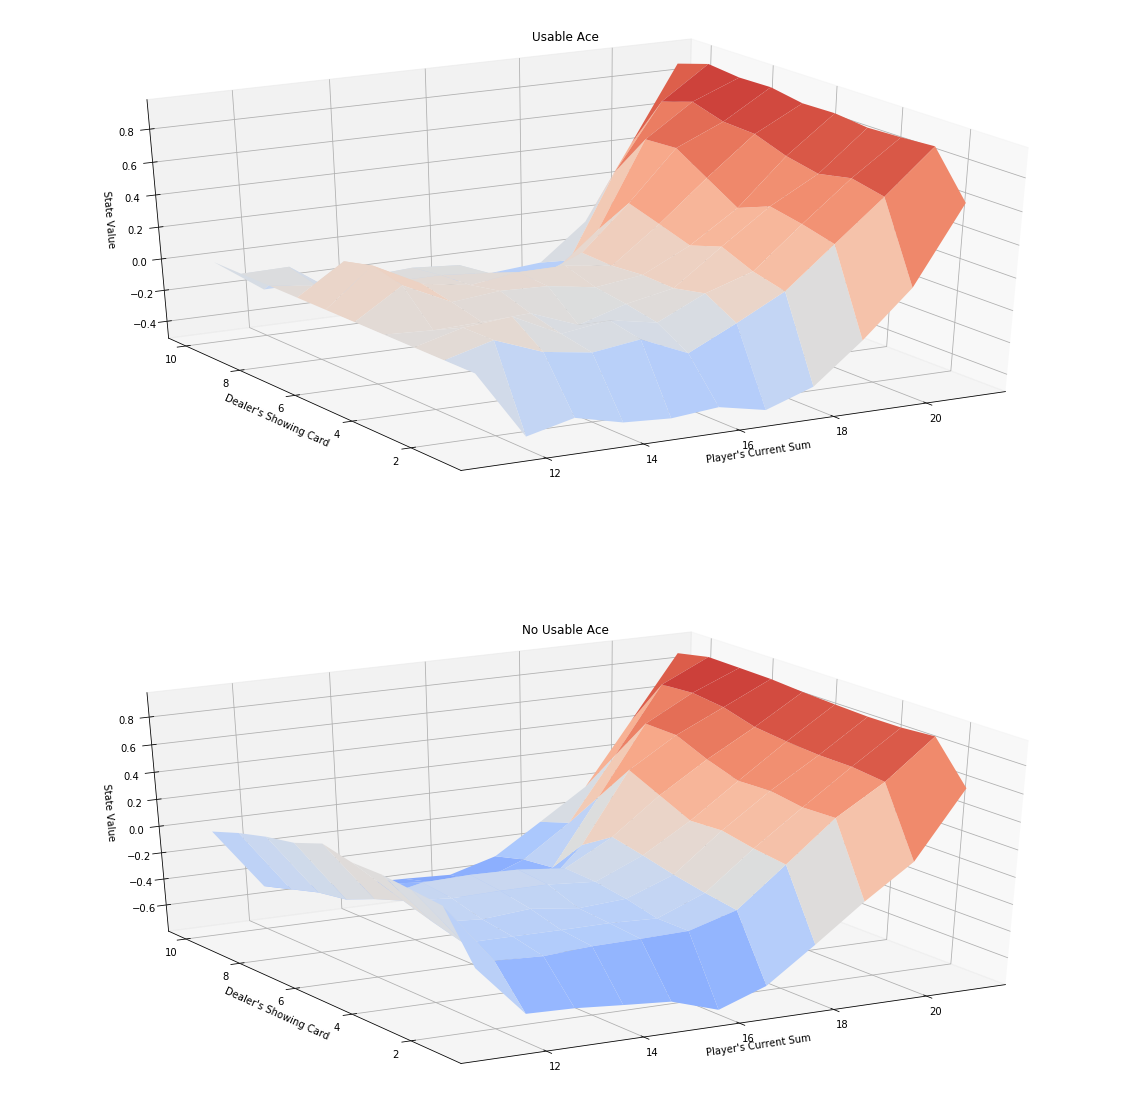

In [12]:
from plot_utils import plot_blackjack_values, plot_blackjack_policy

# obtener funcion estado-valor (para cada estado, el valor maximo de las acciones posibles)
V_to_plot = dict((k, np.max(v)) for k, v in Q.items())

# representar gráficamente la función v(s) = v(puntuacion, carta, as_disponible)
plot_blackjack_values(V_to_plot)

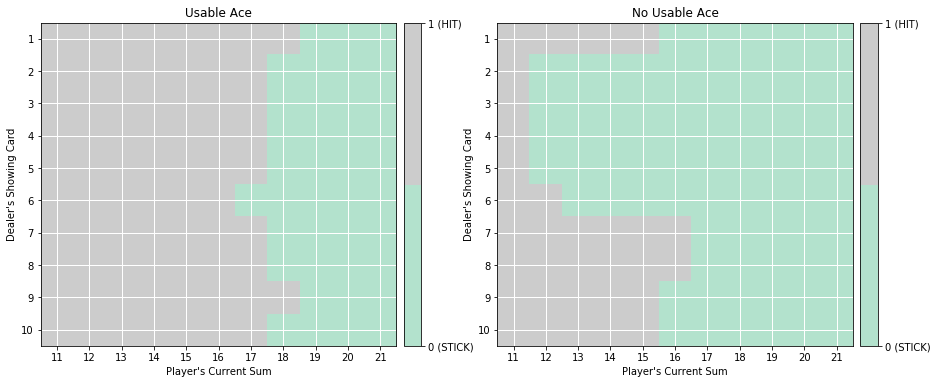

In [11]:
# represent gráficamente la política
plot_blackjack_policy(policy)

---

### EJERCICIO

¿Podrías extender este código para otro de los entornos **discretos** de OpenAI Gym? Por ejemplo, [CliffWalking-v0](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py).


---